## Сбалансированное АВЛ-дерево

https://stepik.org/lesson/41563/step/1

- [--] обход inorder, preorder, postorder (рекурсия)
- [--] обход inorder, preorder, postorder (итеративный)
- [--] обход в глубину (рекурсия и итеративный)
- [--] обход в ширину (рекурсия и итеративный)
- [+]  поиск минимума, максимума
- [+]  поиск предыдущего, следующего
- [--] поиск высоты: рекурсивно, стеком
- [+]  поиск высоты: кешами
- [+]  АВЛ: пересчет кеша высоты, вставка, удаление
- [+]  АВЛ: левое/правое большое/малое вращение
- [--] обращение по индексу
- [--] размер поддерева (и пересчет кеша)
- [+] разрезание, склеивание
- [--] полный пересчет кешей
- [+]  проверка корректности

## Множество с запросами суммы на отрезке

[условия.pdf](https://stepik.org/media/attachments/lesson/41233/statements.pdf)

[проверка результатов](https://stepik.org/lesson/45970/step/4)

Реализуйте структуру данных для хранения множества целых чисел, поддерживающую
запросы добавления, удаления, поиска, а также суммы на отрезке.

На вход в данной задаче будет дана последовательность таких запросов.
Чтобы гарантировать, что ваша программа обрабатывает каждый запрос по мере поступления
(то есть онлайн), каждый запрос будет зависеть от результата выполнения
одного из предыдущих запросов.
Если бы такой зависимости не было, задачу можно было бы решить оффлайн:
сначала прочитать весь вход и сохранить все запросы в каком-нибудь виде,
а потом прочитать вход ещё раз, параллельно отвечая на запросы.

#### Формат входа.

Изначально множество пусто. Первая строка содержит число запросов $n$.
Каждая из $n$ следующих строк содержит запрос в одном из следующих четырёх форматов:
- `+ i`: добавить число $f(i)$ в множество (если оно уже есть, проигнорировать запрос);
- `- i`: удалить число $f(i)$ из множества (если его нет, проигнорировать запрос);
- `? i`: проверить принадлежность числа $f(i)$ множеству;
- `s l r`: посчитать сумму всех элементов множества, попадающих в отрезок $[f(l),f(r)]$.

Функция $f$ определяется следующим образом.
Пусть $s$ — результат последнего запроса суммы на отрезке
(если таких запросов ещё не было, то $s = 0$). Тогда
    $$f(x) = (x + s) \mod 1 000 000 001$$

#### Формат выхода.

Для каждого запроса типа `? i` выведите `Found` или `Not found`.

Для каждого запроса суммы выведите сумму всех элементов множества,
попадающих в отрезок $[f(l),f(r)]$.
Гарантируется, что во всех тестах $f(l) \le f(r)$.

#### Ограничения.
$1 \le n \le 10^5$; $0 \le i \le 10^9$.

In [1]:
%matplotlib inline
from IPython.display import Image, HTML
from IPython.core.debugger import set_trace as trace


def draw_tree(tree):
    from networkx import Graph, draw
    from operator import attrgetter
    
    width = 1
    vgap = .2
    vloc = 0
    xcenter = width / 2
    node_color = 'lightgrey'
    node_size = 1600

    root = tree.root
    if root is None:
        return

    def add_graph_node(node):
        if node not in graph.nodes:
            graph.add_node(node)
            labels[node] = node.label
        left = node.left
        if left is not None:
            add_graph_node(left)
            graph.add_edge(node, left)
        right = node.right
        if right is not None:
            add_graph_node(right)
            graph.add_edge(node, right)

    graph = Graph()
    labels = {}
    add_graph_node(tree.root)

    def layout_hier(root, width, vloc, xcenter, pos=None, parent=None):
        if pos is None:
            pos = { root: (xcenter, vloc) }
        else:
            pos[root] = (xcenter, vloc)
        neighbors = list(graph.neighbors(root))
        if parent is not None:
            neighbors.remove(parent)
        if len(neighbors):
            dx = width / len(neighbors) 
            nextx = xcenter - width/2 - dx/2
            for neighbor in sorted(neighbors, key=attrgetter('key')):
                nextx += dx
                pos = layout_hier(neighbor, width=dx, vloc=vloc-vgap, xcenter=nextx,
                                  pos=pos, parent=root)
        return pos

    return draw(graph,
                pos=layout_hier(root, width, vloc, xcenter),
                with_labels=True, labels=labels,
                node_color=node_color, node_size=node_size)


In [2]:
from collections import Iterable

class SumNode:
    def __init__(self, key=None):
        self.key = self.sum = key
        self._clear()

    def _clear(self):
        self.left = self.right = None
        self.parent = None
        self.height = 0

    @property
    def label(self):
        marker1, marker2 = '[', ']'
        if self.parent:
            if self == self.parent.left and not self.parent.right:
                marker1, marker2 = '[', '...'
            if self == self.parent.right and not self.parent.left:
                marker1, marker2 = '...', ']'
        return '{}\n{}{}{}'.format(
            self.key, marker1, self.sum, marker2)

    def __repr__(self):
        return '["{}" ({}) {},{}]'.format(
            self.key, self.sum,
            '.' if self.left is None else self.left.key,
            '.' if self.right is None else self.right.key,
        )

    @property
    def left_height(self):
        return self.left.height if self.left else -1

    @property
    def right_height(self):
        return self.right.height if self.right else -1

    @property
    def left_sum(self):
        return self.left.sum if self.left else 0

    @property
    def right_sum(self):
        return self.right.sum if self.right else 0

    # вспомогательная операция: обновление высоты и суммы элемента
    def _update_height(self):
        old_h = self.height
        old_s = self.sum
        self.height = 1 + max(self.left_height, self.right_height)
        self.sum = self.key + self.left_sum + self.right_sum
        return self.height != old_h or self.sum != old_s

    
class SumTree:

    def __init__(self, tree=None):
        if isinstance(tree, Iterable):
            self.root = None
            self.add(tree)
        else:
            self.root = tree
            if tree:
                tree.parent = None

    def __repr__(self):
        def walk(node):
            if node:
                yield '[{} {} {}]'.format(
                    node.key,
                    '.' if node.left is None else node.left.key,
                    '.' if node.right is None else node.right.key)
                yield from walk(node.left)
                yield from walk(node.right)
        return '[' + ''.join(walk(self.root)) + ']'

    def find(self, key):
        node, found = self.find_node(key)
        return found

    def add(self, keys):
        if not isinstance(keys, (str, Iterable)):
            keys = [keys]
        for key in keys:
            self.add_node(SumNode(key))
        return self

    def remove(self, keys):
        if not isinstance(keys, (str, Iterable)):
            keys = [keys]
        for key in keys:
            node, found = self.find_node(key)
            if found:
                self.remove_node(node)
        return self

    def find_node(self, key):
        node = parent = self.root
        while node:
            parent = node
            if key > node.key:
                node = node.right
            elif key < node.key:
                node = node.left
            else:
                assert key == node.key
                return node, True
        if parent:
            assert not (parent.left and parent.right)
        return parent, False
    
    def add_node(self, node):
        if not node:
            return False
        if not self.root:
            self.root = node
            node.parent = None
            return True
        parent, found = self.find_node(node.key)
        if found:
            return False
        if parent.key > node.key:
            parent.left = node
        else:
            parent.right = node
        node.parent = parent
        self._rebalance(parent)
        return True

    def remove_node(self, node):
        if not node:
            return
        if node.left and node.right:
            # two children
            orig = node
            node = node.left
            while node.right:
                node = node.right
            node.key, orig.key = orig.key, node.key
            self.remove_node(node)
        else:
            # one child or no children
            parent = node.parent
            child = node.left or node.right
            self._replace_child(node, child)
            node._clear()
            self._rebalance(parent)
        return node

    # вспомогательная операция, которая заменяет ссылку на элемент
    # в его родителе; выделена, т.к. используется очень часто
    def _replace_child(self, old_node, new_node):
        parent = old_node.parent
        old_node.parent = None
        if parent is None:
            assert self.root == old_node
            self.root = new_node
            if new_node:
                new_node.parent = None
            return None
        if old_node == parent.left:
            parent.left = new_node
            if new_node:
                new_node.parent = parent
            return True
        elif old_node == parent.right:
            parent.right = new_node
            if new_node:
                new_node.parent = parent
            return False
        else:
            raise RuntimeError('tree broken')

    # перебалансировка элемента в точности как на лекции
    def _rebalance(self, node, force=False):
        while node:
            left_h = node.left_height
            right_h = node.right_height
            if right_h - left_h > 1:
                beta = node.right
                gamma = beta.left
                if beta.right_height > left_h:
                    # малое правое вращение
                    node.right = gamma
                    if gamma:
                        gamma.parent = node
                    beta.left = node
                    self._replace_child(node, beta)
                    node.parent = beta
                else:
                    # большое правое вращение
                    assert gamma is not None
                    node.right = gamma.left
                    if node.right:
                        node.right.parent = node
                    beta.left = gamma.right
                    if beta.left:
                        beta.left.parent = beta
                    gamma.right = beta
                    beta.parent = gamma
                    beta._update_height()
                    self._replace_child(node, gamma)
                    gamma.left = node
                    node.parent = gamma
                    node.height = -1  # force update
            elif left_h - right_h > 1:
                beta = node.left
                gamma = beta.right
                if beta.left_height > right_h:
                    # малое левое вращение
                    node.left = gamma
                    if gamma:
                        gamma.parent = node
                    beta.right = node
                    self._replace_child(node, beta)
                    node.parent = beta
                else:
                    # большое правое вращение
                    assert gamma is not None
                    node.left = gamma.right
                    if node.left:
                        node.left.parent = node
                    beta.right = gamma.left
                    if beta.right:
                        beta.right.parent = beta
                    gamma.left, beta.parent = beta, gamma
                    beta._update_height()
                    self._replace_child(node, gamma)
                    gamma.right = node
                    node.parent = gamma
                    node.height = -1  # force update
            if not (node._update_height() or force):
                break
            node = node.parent

    # этот метод считает сумму тех элементов, где ключ больше границы
    def _sum_above(self, key):
        node = self.root
        # сначала берём полную сумму
        summ = node.sum if node else 0
        while node:
            if node.key > key:
                # пропускаем элементы, которые больше границы
                node = node.left
                continue
            # у остальных элементов вычитаем их значение и сумму левого поддерева
            summ -= node.key + (node.left.sum if node.left else 0)
            # остановка, если наталкиваемся на точное совпадение ключа
            node = None if node.key == key else node.right
        return summ

    def sum_between(self, left, right):
        # проверка корректности интервала очень важна,
        # т.к. иначе разность будет некорректной
        if right > left:
            # вычитаем из более широкой суммы менее широкую
            return self._sum_above(left-1) - self._sum_above(right)
        elif right == left:
            # если границы равны, можно поступить оптимально
            # и вместо расчёта полных сумм просто проверить наличие совпадения
            return left * self.find(left)
        else:
            return 0


In [3]:
class SumHash:
    def __init__(self, vals=None):
        self.vals = set(vals or [])

    def add(self, val):
        self.vals.add(val)
        return self
        
    def remove(self, val):
        if val in self.vals:
            self.vals.remove(val)
        return self

    def find(self, val):
        return val in self.vals
    
    def sum_between(self, left, right):
        return sum(x for x in self.vals if left <= x <= right)
    

def test_split_sums(Runner, shifting=True, exams=None):
    default_exams = [
        ('+ 491572259;? 491572259;? 899375874;s 310971296 877523306;+ 352411209',
         'Found;Not found;491572259'),
        ('? 1;+ 1;? 1;+ 2;s 1 2;+ 1000000000;? 1000000000;- 1000000000;? 1000000000;s 999999999 1000000000;- 2;? 2;- 0;+ 9;s 0 9',
         'Not found;Found;3;Found;Not found;1;Not found;10'),
        ('? 0;+ 0;? 0;- 0;? 0',
         'Not found;Found;Not found'),
        ]
    
    if exams is None:
        exams = default_exams

    summ = 0
    def f(x):
        x = int(x)
        if shifting:
            x = (x + summ) % 1000000001
        return x

    for lines, expected in exams:
        lines = [str(x).strip() for x in lines.split(';')]
        expected = [str(x).strip() for x in expected.split(';')]
        runner = Runner()
        results = []
        summ = 0
        for line in lines:
            if line[0] == 's':
                try:
                    op, left, right = line.split()
                except ValueError:
                    raise RuntimeError('too values to unpack:\n%s' % line)
                left, right = f(left), f(right)
                summ = runner.sum_between(left, right)
                results.append(str(summ))
                continue
            op, val = line.split()
            val = f(val)
            if op == '?':
                ret = runner.find(val)
                out = ['Not found', 'Found'][ret]
                results.append(out)
            if op == '+':
                runner.add(val)
            elif op == '-':
                runner.remove(val)
        results = ';'.join(results)
        expected = ';'.join(expected)
        assert results == expected, '\nneed %s\ngot  %s' % (expected, results)

    print('OK!')
    

test_split_sums(SumHash)
test_split_sums(SumTree)

OK!
OK!


In [4]:
exam_big = [
    ('s 40279559 89162572;- 774613289;s 869592654 915517087;- 165280355;- 776346290;- 221187096;s 421986248 742826969;s 83228103 852190011;- 640319482;? 528689193;? 75245219;- 617070033;+ 66257759;s 25751289 70170547;s 28248247 617849094;- 954357244;+ 477444954;? 608389416;s 400483980 423330836;- 477444954;? 441393551;s 66257759 66257759;- 822218158;? 806479414;s 548665149 925635534;s 66257759 66257759;? 234121006;+ 663305907;s 314809050 685231317;- 0;s 487458874 602635501;s 66257759 66257759;? 918193520;? 606474691;s 188185089 774086933;- 322445571;s 66257759 66257759;- 814123984;s 0 0;s 0 0;s 689260392 827869844;? 204276815;- 66257759;? 488766408;s 412617563 631410280;- 463415495;+ 601030115;? 776513589;s 257003372 887483600;+ 154047223;? 154047223;? 219327735;+ 978812473;s 978812473 154047223;? 718062555;? 128066784;- 15718305;? 754978417;s 643892549 819127300;? 192401474;? 643892549;+ 638898307;? 973173529;+ 506709268;- 506709268;+ 744166533;- 638898307;+ 95240753;s 997348833 63778002;? 31190791;s 21011834 570648768;+ 217208615;+ 401912531;s 0 723886547;? 251082460;+ 542593404;s 702430665 542593404;? 48285749;s 831077135 671239874;+ 917941607;? 908494561;? 671239874;s 333354822 490605331;+ 261522346;s 170201520 10364259;- 139162050;- 677374727;? 992422786;? 500171144;- 239436034;+ 556867643;? 992422786;+ 720003678;s 220110584 268880636;s 31190791 997548180;s 898610232 383552107',
     '0;0;0;0;Not found;Not found;66257759;66257759;Not found;0;Not found;66257759;Not found;0;66257759;Not found;663305907;0;66257759;Not found;Not found;663305907;66257759;0;0;0;Not found;Not found;0;Not found;1264336022;Found;Not found;0;Not found;Not found;Not found;663305907;Not found;Not found;Not found;0;Not found;249287976;2132745144;Not found;0;Not found;0;Not found;Not found;401912531;0;Not found;Not found;Not found;261522346;6854652828;0')
]
exam2 = [('+ 60;+ 15;+ 97;s 97 15','0')]
test_split_sums(SumHash, False, exam2)
test_split_sums(SumTree, False, exam2)

OK!
OK!


33 34 38 70 78 15 22 23
127
127
OK


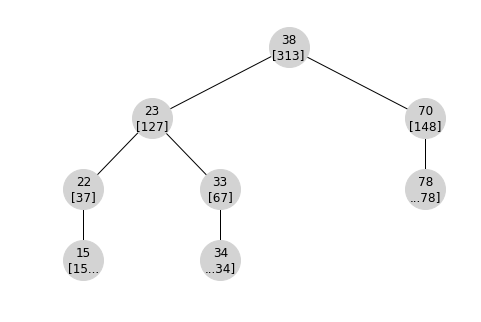

In [5]:
def test2():
    add1 = '38 33 70 34 78 22 24 15 23'
    add1 = list(map(int, add1.split()))
    sub1 = [24]
    l, r = 1, 34
    sh = SumHash()
    st = SumTree()
    for val in add1:
        sh.add(val)
        st.add(val)
    for val in sub1:
        sh.remove(val)
        st.remove(val)
    print(*sh.vals)
    print(sh.sum_between(l, r))
    print(st.sum_between(l, r))
    assert sh.sum_between(l, r) == st.sum_between(l, r)
    print("OK")
    return draw_tree(st)

test2()

In [6]:
import random
def test1():
    random.seed(12345)
    minval, maxval, loops = 0, 100, 20
    add1 = sorted(set([random.randint(minval,maxval) for _ in range(loops)]))
    sub1 = sorted(set([random.randint(minval,maxval) for _ in range(loops)]))
    random.shuffle(add1)
    random.shuffle(sub1)
    for x in sorted(sub1):
        if x not in add1:
            sub1.remove(x)
    sh = SumHash()
    st = SumTree()
    for val in add1:
        sh.add(val)
        st.add(val)
    for val in sub1:
        sh.remove(val)
        st.remove(val)
    for l in range(minval-2, maxval+2):
        for r in range(minval-2, maxval+2):
            sh_sum = sh.sum_between(l, r)
            st_sum = st.sum_between(l, r)
            if sh_sum != st_sum:
                print('ERROR')
                print(*add1)
                print(*sub1)
                print(*sorted(sh.vals))
                print(l, r)
                print(sh_sum, st_sum)
                return
    print('OK')

test1()

OK


# ==============
# Exam
# ==============

In [7]:
%%writefile tree-avl-sum.py

class SumNode:
    def __init__(self, key=None):
        self.key = self.sum = key
        self._clear()

    def _clear(self):
        self.left = self.right = None
        self.parent = None
        self.height = 0

    @property
    def left_height(self):
        return self.left.height if self.left else -1

    @property
    def right_height(self):
        return self.right.height if self.right else -1

    @property
    def left_sum(self):
        return self.left.sum if self.left else 0

    @property
    def right_sum(self):
        return self.right.sum if self.right else 0

    # вспомогательная операция: обновление высоты и суммы элемента
    def _update_height(self):
        old_h = self.height
        old_s = self.sum
        self.height = 1 + max(self.left_height, self.right_height)
        self.sum = self.key + self.left_sum + self.right_sum
        return self.height != old_h or self.sum != old_s


class SumTree:
    def __init__(self):
        self.root = None

    def find(self, key):
        node, found = self.find_node(key)
        return found

    def add(self, key):
        self.add_node(SumNode(key))

    def remove(self, key):
        node, found = self.find_node(key)
        if found:
            self.remove_node(node)

    def find_node(self, key):
        node = parent = self.root
        while node:
            parent = node
            if key > node.key:
                node = node.right
            elif key < node.key:
                node = node.left
            else:
                assert key == node.key
                return node, True
        if parent:
            assert not (parent.left and parent.right)
        return parent, False

    def add_node(self, node):
        if not node:
            return False
        if not self.root:
            self.root = node
            node.parent = None
            return True
        parent, found = self.find_node(node.key)
        if found:
            return False
        if parent.key > node.key:
            parent.left = node
        else:
            parent.right = node
        node.parent = parent
        self._rebalance(parent)
        return True

    def remove_node(self, node):
        if not node:
            return
        if node.left and node.right:
            # two children
            orig = node
            node = node.left
            while node.right:
                node = node.right
            node.key, orig.key = orig.key, node.key
            self.remove_node(node)
        else:
            # one child or no children
            parent = node.parent
            child = node.left or node.right
            self._replace_child(node, child)
            node._clear()
            self._rebalance(parent)
        return node

    # вспомогательная операция, которая заменяет ссылку на элемент
    # в его родителе; выделена, т.к. используется очень часто
    def _replace_child(self, old_node, new_node):
        parent = old_node.parent
        old_node.parent = None
        if parent is None:
            assert self.root == old_node
            self.root = new_node
            if new_node:
                new_node.parent = None
            return None
        if old_node == parent.left:
            parent.left = new_node
            if new_node:
                new_node.parent = parent
            return True
        elif old_node == parent.right:
            parent.right = new_node
            if new_node:
                new_node.parent = parent
            return False
        else:
            raise RuntimeError('tree broken')

    # перебалансировка элемента в точности как на лекции
    def _rebalance(self, node, force=False):
        while node:
            left_h = node.left_height
            right_h = node.right_height
            if right_h - left_h > 1:
                beta = node.right
                gamma = beta.left
                if beta.right_height > left_h:
                    # малое правое вращение
                    node.right = gamma
                    if gamma:
                        gamma.parent = node
                    beta.left = node
                    self._replace_child(node, beta)
                    node.parent = beta
                else:
                    # большое правое вращение
                    assert gamma is not None
                    node.right = gamma.left
                    if node.right:
                        node.right.parent = node
                    beta.left = gamma.right
                    if beta.left:
                        beta.left.parent = beta
                    gamma.right = beta
                    beta.parent = gamma
                    beta._update_height()
                    self._replace_child(node, gamma)
                    gamma.left = node
                    node.parent = gamma
                    node.height = -1  # force update
            elif left_h - right_h > 1:
                beta = node.left
                gamma = beta.right
                if beta.left_height > right_h:
                    # малое левое вращение
                    node.left = gamma
                    if gamma:
                        gamma.parent = node
                    beta.right = node
                    self._replace_child(node, beta)
                    node.parent = beta
                else:
                    # большое правое вращение
                    assert gamma is not None
                    node.left = gamma.right
                    if node.left:
                        node.left.parent = node
                    beta.right = gamma.left
                    if beta.right:
                        beta.right.parent = beta
                    gamma.left, beta.parent = beta, gamma
                    beta._update_height()
                    self._replace_child(node, gamma)
                    gamma.right = node
                    node.parent = gamma
                    node.height = -1  # force update
            if not (node._update_height() or force):
                break
            node = node.parent

    # сплит и склеивание деревьев тоже работало, но мне не удалось
    # добиться прохождения тестов по скорости, поэтому я поступил иначе.
    # так я придумал неразрушающий метод _sum_above() со временем работы
    # пропорционально высоте дерева, то есть O(log N).
    # этот метод считает сумму тех элементов, где ключ больше границы
    def _sum_above(self, key):
        node = self.root
        # сначала берём полную сумму
        summ = node.sum if node else 0
        while node:
            if node.key > key:
                # пропускаем элементы, которые больше границы
                node = node.left
                continue
            # у остальных элементов вычитаем их значение и сумму левого поддерева
            summ -= node.key + (node.left.sum if node.left else 0)
            # остановка, если наталкиваемся на точное совпадение ключа
            node = None if node.key == key else node.right
        return summ

    def sum_between(self, left, right):
        # проверка корректности интервала очень важна,
        # т.к. иначе разность будет некорректной
        if right > left:
            # вычитаем из более широкой суммы менее широкую
            return self._sum_above(left-1) - self._sum_above(right)
        elif right == left:
            # если границы равны, можно поступить оптимально
            # и вместо расчёта полных сумм просто проверить наличие совпадения
            return left * self.find(left)
        else:
            return 0


def main():
    from sys import stdin

    summ = 0
    tree = SumTree()

    def f(x):
        return (int(x) + summ) % 1000000001

    # число задач не нужно, просто читаем вход до конца
    next(stdin)

    for line in stdin:
        if line[0] == 's':
            op, left, right = line.split()
            left, right = f(left), f(right)
            summ = tree.sum_between(left, right)
            print(summ)
            continue

        op, val = line.split()
        val = f(val)
        if op == '?':
            print(['Not found', 'Found'][tree.find(val)])
        if op == '+':
            tree.add(val)
        elif op == '-':
            tree.remove(val)


if __name__ == '__main__':
    main()


Overwriting tree-avl-sum.py


In [8]:
%%bash
python3 tree-avl-sum.py << EOF
15
? 1
+ 1
? 1
+ 2
s 1 2
+ 1000000000
? 1000000000
- 1000000000
? 1000000000
s 999999999 1000000000
- 2
? 2
- 0
+ 9
s 0 9
EOF
# expected: Not found;Found;3;Found;Not found;1;Not found;10

Not found
Found
3
Found
Not found
1
Not found
10


In [9]:
%%bash
python3 tree-avl-sum.py << EOF
5
? 0
+ 0
? 0
- 0
? 0
EOF
# expected: Not found;Found;Not found

Not found
Found
Not found


In [10]:
%%bash
python3 tree-avl-sum.py << EOF
5
+ 491572259
? 491572259
? 899375874
s 310971296 877523306
+ 352411209
EOF
# expected: Found;Not found;491572259

Found
Not found
491572259
